進入Monte Carlo的範例之後，我們知道，MC的一個主要就是會從跟環境的互動中取得經驗，再利用這個經驗來優化agent，所以我們就試著從架構環境開始，範例上會參考[dennybritz](https://github.com/dennybritz/reinforcement-learning/tree/master/MC)，再加上自己的理解說明。

這個範例主要是Monte Carlo + off-policy + weigthed important sampling

off-policy之所以會稱為off-policy是因為它的target policy與behvaior policy是不同的(當它們是一樣的時候你也可以將之視為是off-policy的特例)。這時候你的episode是由behavior policy所得，要用它來估測target policy就必需要引入important sampling ratio。

參考的來源作者主要是利用openai所open的gym來實作環境，這部份倒是可以看個人

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

%matplotlib inline

下面先設置一些類別需要的函數，這也是看個人的習慣

action space，要牌(0)、停牌(1)

In [2]:
action_space = [0, 1] 

牌組，1~10、J、Q、K

In [3]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] 

設置抽牌的函數

In [4]:
def draw_card(deck):
    """隨機從牌組中抽一張牌"""
    return np.random.choice(deck)

In [5]:
draw_card(deck)

10

In [6]:
def draw_hand(deck):
    """回傳一個牌組，也就是兩張牌"""
    return [draw_card(deck), draw_card(deck)]

In [7]:
draw_hand(deck)

[10, 10]

In [8]:
def usable_ace(hand):
    """判斷牌組內是否有用ace
    
    只要牌組內有ace(1)，然後牌組的總和小於等於21，就視為將ace做為11使用
    """
    return 1 in hand and sum(hand) + 10 <= 21

In [9]:
hand = draw_hand(deck)
print(hand, usable_ace(hand))

[1, 8] True


In [10]:
def sum_hand(hand):
    """加總牌組，過程中會判斷是否有將ace做為11使用"""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

In [11]:
sum_hand(hand)

19

In [12]:
def is_bust(hand):
    """判斷牌組是否已經爆牌"""
    return sum(hand) > 21

In [13]:
is_bust(hand)

False

In [14]:
def score(hand):  
    """還不是很清楚設置這一個函數的用意
    
    這個函數看起來就是以牌組的總和為值回傳，前提是沒有爆牌
    """
    return 0 if is_bust(hand) else sum_hand(hand)

In [15]:
score(hand)

19

下面開始設置環境

In [16]:
class BlackjackEnv():
    """21點的模擬環境，相關書本中的內容可以參考上面說明"""
    def __init__(self, action_space, deck):
        """
        action_space: 要牌、停牌
        deck: 牌組
        """
        self.action_space = action_space
        self.deck = deck
        self.action_nums = len(self.action_space)        
        
        # 初始的時候先重置牌局
        self.reset()
        
    def get_observation(self):
        """回傳當前的觀察狀態
        
        依課本說明，回傳的為[玩家的牌組總合, 庄家的1張牌, 是否將ace視為11]
        """
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))
    
    def reset(self):
        """賽局重置
        
        重置賽局的時候我們會重新發給玩家跟庄家牌組，
        只要玩家的牌組是小於12，那就再給牌，補到12
        
        return:
            observation，[玩家的牌組總合, 庄家的1張牌, 是否將ace視為11]
        """
        self.dealer = draw_hand(self.deck)
        self.player = draw_hand(self.deck)
        
        # 玩家的牌如果小於12就直接補牌
        while sum_hand(self.player) < 12:
            self.player.append(draw_card(self.deck))
        
        return self.get_observation()
        
    def step(self, action):
        """與環境的互動
        
        每個time step根據觀測到的狀態來決定一個action，
        在執行一個action之後環境就會產生新的狀態，並計算得到的reward
        其中reward贏牌+1、和牌+0、輸牌-1
        
        如果要牌，就發一張牌，然後判斷是不是有爆，
        如果停牌，那就換庄家補牌到17以上，庄家爆牌就玩家贏
        不然就是兩個比較大小決定誰贏
        
        return:
            next observation、reward、done
        """
        assert action in self.action_space
        
        # 要牌
        if action:
            self.player.append(draw_card(self.deck))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else: # 停牌
            done = True               
            
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.deck))            
            
            if is_bust(self.dealer):
                reward = 1
            elif sum_hand(self.player) == sum_hand(self.dealer):
                reward = 0
            elif sum_hand(self.player) < sum_hand(self.dealer): 
                reward = -1
            elif sum_hand(self.player) > sum_hand(self.dealer):
                reward = 1
        
        return self.get_observation(), reward, done
            
        
            
            

new一個環境

In [17]:
env = BlackjackEnv(action_space, deck)

In [18]:
env.get_observation()

(15, 1, False)

首先設置policy，根據書中所說，behavior policy就是一個兩相好的policy，要牌、停牌是等機率的，而target policy是一個greedy policy

In [19]:
def createa_behavior_policy(nA):
    """behavior policy
    要牌、停牌是等機率的，因此直接就除上你有幾個action
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [20]:
def create_target_policy(Q):
    """target policy
    greedy policy，因此需要有action-value function
    
    numpy.zeros_like: 回傳一個跟參考的numpy array一樣維度的zero array
    我們的action有兩個，因此得到的是一個[0.0, 0.0]的array
    """
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

這邊也給出every-visit MC off-policy的weighted important sampling的pseudocode

![](https://i.imgur.com/tgFAstY.png)

In [21]:
def example5_4_mc_important_sampling(episodes, env, behavior_policy, discount_factor=1.0):
    """根據課本中5.1的範例設置的Monte Carlo
    
    episodes: 預計執行的賽局次數
    env: 模擬的環境
    behavior_policy: behavior policy
    discount_factory: 折扣因子，範例中為1
        
    我們會根據Monte Carlo的特性，利用sample來模擬很多的賽局，
    再根據賽局的結果來優化action-value function        
    
    過程中會有個Q，也就是action-value function來記錄
    也會有一個C，也就是累加計算重要性抽樣的分母，這邊記錄的是所有episode的
    這個部份你可以把它視為就是公式5.6的分母
    
    return 
        Q: state-action value function
        target policy
    """
      
    # action-value function
    Q = defaultdict(lambda: np.zeros(env.action_nums))
    # 累績計算加權重要性抽樣的分母
    C = defaultdict(lambda: np.zeros(env.action_nums))
        
    # 設置target policy
    target_policy = create_target_policy(Q)
    
    for epi in range(1, episodes + 1):
        trajectory = []
        # 每個episode的開場都會重新開局這個賽局
        state = env.reset()
        # 這邊的作法是假設你在100次互動內會完成這場賽局
        # 雖然實務上很難到100次互動啦，總之爆了就結束這樣
        for i in range(100):
            # behvaior policy中取得action的機率分佈
            probs = behavior_policy(state)            
            # 從得到的機率分佈中sample一個action
            action = np.random.choice(np.arange(len(probs)), p=probs)            
            # 取得與環境互動的結果
            next_state, reward, done = env.step(action)
            # 記錄軌跡
            trajectory.append((state, action, reward))
            # 如果牌局結束那停止迭代
            if done:
                break
            state = next_state
        
        # expected returns
        G = 0.0 
        # 重要性抽樣
        W = 1.0
        
        # 要注意，我們是後面往前去看time step
        # 記得搭配上面的pseudocode
        for time_step in range(len(trajectory))[::-1]:
            # 取出trajectory內的記錄
            t_state, t_action, t_reward = trajectory[time_step]
            # 計算return
            G = discount_factor * G + t_reward
            # 計算state-action pair的累績加權
            C[state][action] += W
            # 依公式計算action-value function
            # 這邊對應的應該就是公式5.8的部份，採用的是incremental
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # 如果target policy的action跟behavior不一樣，那就中止這個time step的計算
            # 因為那就是0
            if t_action != np.argmax(target_policy(t_state)):
                break
            # 這邊猜測，因為target policy是greedy
            # 因此在某個state選中某一個action的機率就是1
            # 這從上面的create target policy也可以看的到
            # 針對Q value最高的那一個所給定的機率就是1.
            # 其實已這個案例兩個action是等機率的來看，直接除上1/nA也行
            W = W * 1. / behavior_policy(state)[action] 
    return Q, target_policy
            

來試玩10局吧

In [22]:
env = BlackjackEnv(action_space, deck)
b_policy = createa_behavior_policy(env.action_nums)
Q_10, policy = example5_4_mc_important_sampling(10, env, b_policy)

In [23]:
Q_10

defaultdict(<function __main__.example5_4_mc_important_sampling.<locals>.<lambda>()>,
            {(15, 3, False): array([ 0., -1.]),
             (21, 6, False): array([ 0., -1.]),
             (13, 6, False): array([ 0., -1.]),
             (12, 10, False): array([-1.,  0.]),
             (20, 5, False): array([ 0., -1.]),
             (12, 4, False): array([1., 0.]),
             (17, 4, False): array([ 0., -1.]),
             (17, 3, False): array([ 0., -1.]),
             (19, 3, False): array([ 0., -1.])})

課本中是以玩10,000與500,000來做比較，我們也試一下

In [24]:
%%time
env = BlackjackEnv(action_space, deck)
b_policy = createa_behavior_policy(env.action_nums)
Q_10k, policy = example5_4_mc_important_sampling(10000, env, b_policy)

CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.5 s


In [25]:
%%time
env = BlackjackEnv(action_space, deck)
b_policy = createa_behavior_policy(env.action_nums)
Q_500k, policy = example5_4_mc_important_sampling(500000, env, b_policy)

CPU times: user 1min 13s, sys: 0 ns, total: 1min 13s
Wall time: 1min 13s


In [26]:
Q_500k[(12,2,0)]

array([-0.28527371, -1.        ])

In [27]:
policy((12, 2, 0))

array([1., 0.])

下面我們用dennybritz所寫的繪圖函數，主要使用的是3D的模組，一些細節說明可以看Example 5.1，這邊不再重覆說明

In [28]:
def plot_value_function(V, title="Value Function"):
    """繪製value function
    
    我們的圖表會有兩張圖與三個維度：
        兩張圖分別為有沒有把ace視為11使用
        三個維度為：
        (1)玩家的牌組(因為玩家的牌預設已經是大於等於12以上，因此會從12開始)
        (2)庄家亮出的牌
        (3)該state的value
    """
    # 這邊整理的是玩家的牌與庄家的牌最小值與最大值
    # 不過個人認為，因為範例上一開始已經限定值域了，因此應該可以直接硬性設定即可        
#     min_x = min(k[0] for k in V.keys())
#     max_x = max(k[0] for k in V.keys())
#     min_y = min(k[1] for k in V.keys())
#     max_y = max(k[1] for k in V.keys())
    min_x, max_x, min_y, max_y = 12, 21, 1, 10
        
    x_range = np.arange(min_x, max_x + 1)    
    y_range = np.arange(min_y, max_y + 1)
    # np.meshgrid是一個生成座標矩陣的函數    
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    # np.apply_along_axis就是一種人如其名的函數，針對某一個軸向執行某一個函數
    # 主要是取得把ace視為11與不視為11的資料
    # 回傳的value function是一個defaultdict(float)的資料
    # 因此利用座標去詢條件，舉例來說，V[0, 0, False]，有值有值，沒有值就是0
    # 如果還不是很清楚可以看上面的分段執行的結果就不難理解這邊處理的手法
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title):
        # 定義figure的大小
        fig = plt.figure(figsize=(20, 10))
        # 增加一個3d的子圖表
        ax = fig.add_subplot(111, projection='3d')
        # rstride、cstride: 座標軸的間距大小
        # vmin, vmax: value的最大最小值，
        # cmap: 色彩配置
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        # 視角的設置
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

因為我們的Q是action-value function，所以要做一點處理

In [29]:
for state, action in Q_10.items():
    print(state, action)

(15, 3, False) [ 0. -1.]
(21, 6, False) [ 0. -1.]
(13, 6, False) [ 0. -1.]
(12, 10, False) [-1.  0.]
(20, 5, False) [ 0. -1.]
(12, 4, False) [1. 0.]
(17, 4, False) [ 0. -1.]
(17, 3, False) [ 0. -1.]
(19, 3, False) [ 0. -1.]


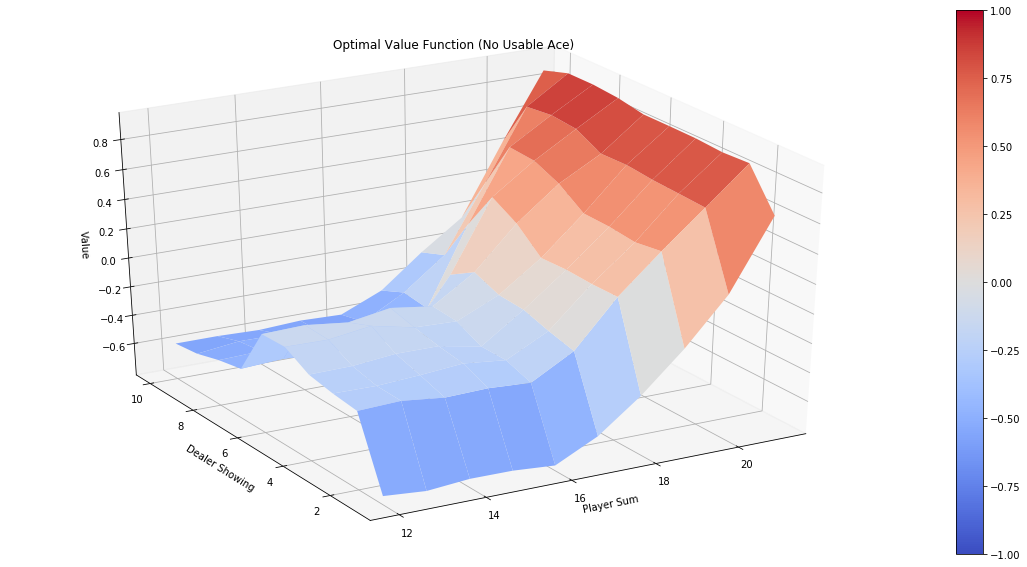

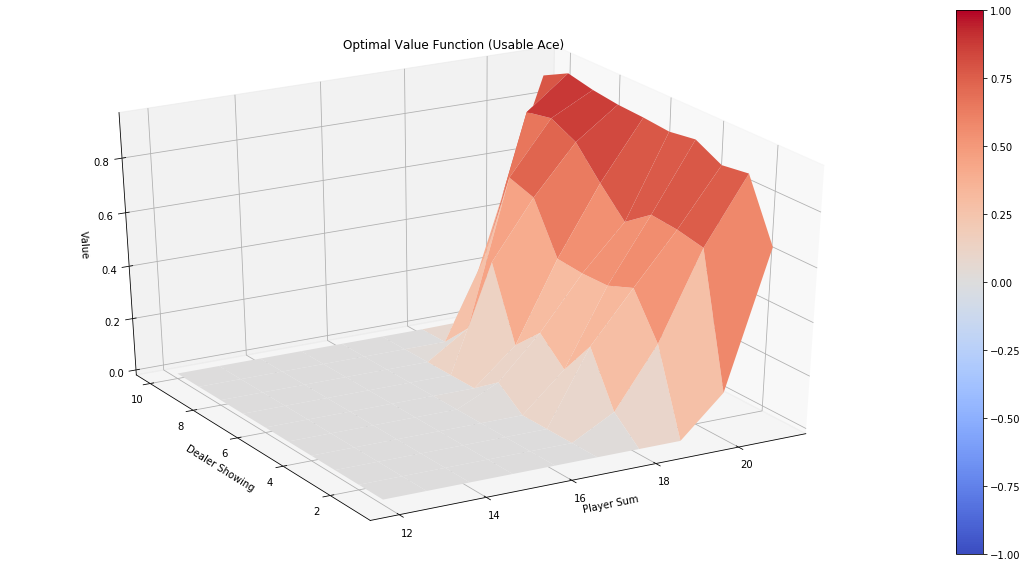

In [30]:
V = defaultdict(float)

for state, action in Q_500k.items():
    action_value = np.max(action)
    V[state] = action_value
plot_value_function(V, 'Optimal Value Function')  

得到的結果跟參考來源不同，猜測是因為seed的設置，不過已經到500000局還會有差異，不是不夠多局就是我的程式碼真的有錯誤。